In [1]:
# Loading Libraries in The Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.metrics import classification_report,roc_curve, roc_auc_score,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
import re

## Loading Dataset

In [2]:
df_past=pd.read_csv('NEO Earth Close Approaches_past.csv')
df_past.head()

,Object,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity
0,509352 (2007 AG),1900-Jan-04 22:25 ± 00:02,0.00963,0.00962,8.69,8.65,20.2,250 m - 550 m,2
1,(2014 SC324),1900-Jan-11 01:07 ± 00:18,0.03997,0.03991,10.65,10.65,24.4,35 m - 79 m,0
2,(2012 UK171),1900-Jan-12 23:07 ± 00:13,0.04982,0.04950,7.16,7.15,24.4,35 m - 77 m,0
3,(2024 BW1),1900-Jan-25 19:29 ± 4_11:16,0.03798,0.01013,6.34,6.33,25.1,25 m - 56 m,0
4,4660 Nereus (1982 DB),1900-Jan-29 18:09 ± 00:35,0.02080,0.02077,5.54,5.52,18.8,0.33±0.05 km,2


In [3]:
# Load the dataset
df_future=pd.read_csv('NEO_future.csv')
df_future.head()

,Object,Close-Approach (CA) Date,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter,Rarity
0,(2024 KA1),2024-Jun-07 11:06 ± < 00:01,0.01255,0.01254,8.32,8.30,25.3,23 m - 51 m,0.0
1,(2024 LA),2024-Jun-07 22:20 ± < 00:01,0.01204,0.01197,18.28,18.27,25.8,18 m - 41 m,0.0
2,(2024 LC),2024-Jun-08 12:18 ± < 00:01,0.03137,0.03122,8.71,8.70,25.6,20 m - 45 m,0.0
3,(2024 CR9),2024-Jun-11 00:03 ± < 00:01,0.04924,0.04924,7.38,7.37,19.5,340 m - 760 m,1.0
4,(2024 LD),2024-Jun-11 11:06 ± 00:02,0.03093,0.03067,10.68,10.67,26.1,16 m - 36 m,0.0


In [4]:
df=pd.concat([df_past,df_future],axis=0)
df=df.reset_index(drop=True)

In [5]:
#data.column method returns an array of columns list.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29918 entries, 0 to 29917
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Object                    29918 non-null  object 
 1   Close-Approach (CA) Date  29918 non-null  object 
 2   CA DistanceNominal (au)   29918 non-null  float64
 3   CA DistanceMinimum (au)   29918 non-null  float64
 4   V relative(km/s)          29918 non-null  float64
 5   V infinity(km/s)          29910 non-null  float64
 6   H(mag)                    29916 non-null  float64
 7   Diameter                  29916 non-null  object 
 8   Rarity                    29916 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.1+ MB


# data cleaning

In [6]:
df=df.dropna(axis=0)

In [7]:
# Function to parse diameter values
def parse_diameter(diameter):
    range_match = re.match(r'(\d+\.?\d*)\s*m\s*-\s*(\d+\.?\d*)\s*m', diameter)
    if range_match:
        min_diameter = float(range_match.group(1))
        max_diameter = float(range_match.group(2))
        return (min_diameter + max_diameter) / 2

    uncertainty_match = re.match(r'(\d+\.?\d*)±(\d+\.?\d*)\s*km', diameter)
    if uncertainty_match:
        value = float(uncertainty_match.group(1))
        return value * 1000  # Convert km to meters

    single_value_match = re.match(r'(\d+\.?\d*)\s*km', diameter)
    if single_value_match:
        value = float(single_value_match.group(1))
        return value * 1000  # Convert km to meters

    single_value_match = re.match(r'(\d+\.?\d*)\s*m', diameter)
    if single_value_match:
        value = float(single_value_match.group(1))
        return value

    return np.nan


In [8]:

# Apply the parsing function
df['Diameter_Parsed'] = df['Diameter'].apply(parse_diameter)

# Handle missing values
df['Diameter_Parsed'].fillna(df['Diameter_Parsed'].mean(), inplace=True)



In [9]:
# Function to parse the close approach date and time
def parse_ca_date(ca_date_str):
    # Split the string on '±' and take the first part (date and time)
    date_time_str = ca_date_str.split('±')[0].strip()
    # Parse the date and time
    return pd.to_datetime(date_time_str, format='%Y-%b-%d %H:%M', errors='coerce')

# Apply the parsing function to the 'Close-Approach (CA) Date' column
df['CA_Date_Parsed'] = df['Close-Approach (CA) Date'].apply(parse_ca_date)


In [10]:
# Extract components from the datetime
df['CA_Year'] = df['CA_Date_Parsed'].dt.year
df['CA_Month'] = df['CA_Date_Parsed'].dt.month
df['CA_Day'] = df['CA_Date_Parsed'].dt.day
df['CA_Hour'] = df['CA_Date_Parsed'].dt.hour
df['CA_Minute'] = df['CA_Date_Parsed'].dt.minute
df=df.drop(['CA_Date_Parsed','Close-Approach (CA) Date','Object','Diameter'],axis=1)

In [11]:
# Function to categorize Rarity
def categorize_rarity(rarity):
    if rarity in [0.0, 1.0]:
        return 'Frequent'  # Frequent
    elif rarity in [2.0]:
        return 'Moderate'  # Moderate
    elif rarity in [3.0,4.0, 5.0, 6.0]:
        return 'Rare'  # Rare

# Apply categorization
df['Rarity'] = df['Rarity'].apply(categorize_rarity)

In [12]:
df['Rarity'].value_counts()

Rarity
Frequent    27208
Moderate     2292
Rare          408
Name: count, dtype: int64

In [13]:
# Information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29908 entries, 0 to 29917
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CA DistanceNominal (au)  29908 non-null  float64
 1   CA DistanceMinimum (au)  29908 non-null  float64
 2   V relative(km/s)         29908 non-null  float64
 3   V infinity(km/s)         29908 non-null  float64
 4   H(mag)                   29908 non-null  float64
 5   Rarity                   29908 non-null  object 
 6   Diameter_Parsed          29908 non-null  float64
 7   CA_Year                  29908 non-null  int32  
 8   CA_Month                 29908 non-null  int32  
 9   CA_Day                   29908 non-null  int32  
 10  CA_Hour                  29908 non-null  int32  
 11  CA_Minute                29908 non-null  int32  
dtypes: float64(6), int32(5), object(1)
memory usage: 2.4+ MB


In [14]:
# Describes the dataset
df.describe()

,CA DistanceNominal (au),CA DistanceMinimum (au),V relative(km/s),V infinity(km/s),H(mag),Diameter_Parsed,CA_Year,CA_Month,CA_Day,CA_Hour,CA_Minute
count,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000,29908.000000
mean,0.030738,0.026819,10.959227,10.943645,24.087298,125.888822,2043.046977,6.574696,15.632573,11.514779,29.362345
std,0.012530,0.013608,5.566818,5.574213,2.433403,225.067609,70.831207,3.546217,8.852800,6.927949,17.287075
min,0.000210,0.000000,0.390000,0.170000,14.100000,1.090000,1900.000000,1.000000,1.000000,0.000000,0.000000
25%,0.021150,0.015928,7.000000,6.980000,22.600000,32.000000,2006.000000,3.000000,8.000000,6.000000,14.000000
50%,0.032160,0.027490,9.840000,9.830000,24.600000,51.500000,2025.000000,6.000000,16.000000,11.000000,30.000000
75%,0.041440,0.038300,13.820000,13.820000,25.600000,129.500000,2092.000000,10.000000,23.000000,18.000000,44.000000
max,0.050000,0.050000,41.970000,41.970000,33.000000,7000.000000,2200.000000,12.000000,31.000000,23.000000,59.000000


# Exploratory Data Analysis

## Checking For Null Values

In [15]:
# Checking for null values in the dataset
nulls = pd.DataFrame(df.isnull().sum(), columns=['Total'])
nulls['Total Percentage'] = df.isnull().sum() / len(df) * 100
nulls

,Total,Total Percentage
CA DistanceNominal (au),0,0.0
CA DistanceMinimum (au),0,0.0
V relative(km/s),0,0.0
V infinity(km/s),0,0.0
H(mag),0,0.0
Rarity,0,0.0
Diameter_Parsed,0,0.0
CA_Year,0,0.0
CA_Month,0,0.0
CA_Day,0,0.0


<Axes: >

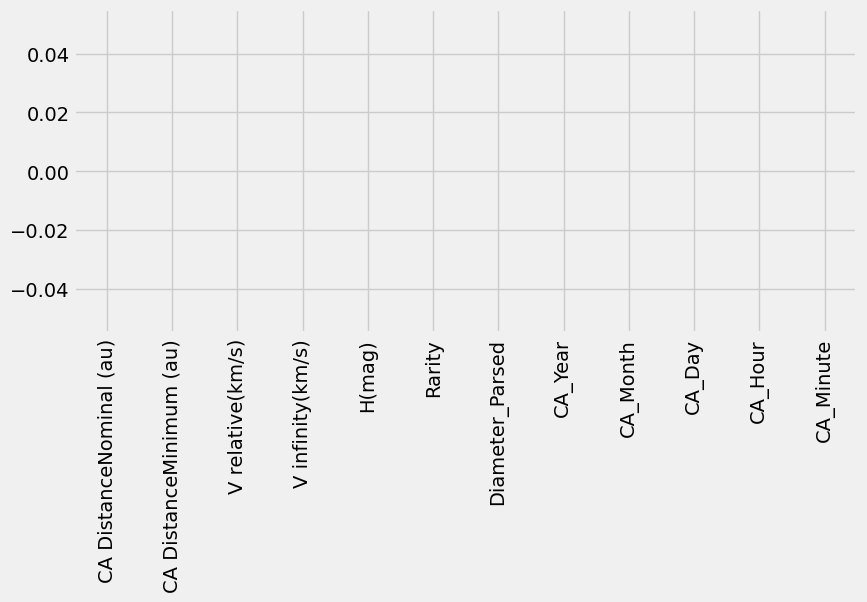

In [16]:
# Plotting Graph of Missing Values
Miss_val = df.isna().sum()/ len(df) * 100
Miss_val.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(9,4))
Miss_val.plot.bar()

## Class Distribution

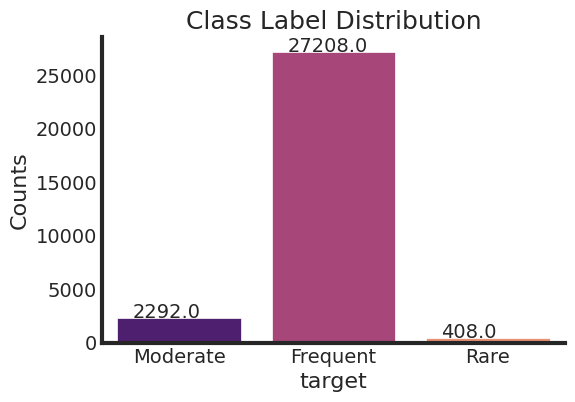

In [17]:
# Seaborn Library
sns.set_style("white")
g = sns.catplot(x="Rarity", data=df, kind="count",
                   palette="magma", height=4, aspect=1.5)
g.ax.xaxis.set_label_text("target",fontdict= {'size':16})
g.ax.yaxis.set_label_text("Counts", fontdict= {'size':16})
g.ax.set_title("Class Label Distribution",fontdict= {'size':18})
# to get the counts on the top heads of the bar
for p in g.ax.patches:
    g.ax.annotate((p.get_height()), (p.get_x()+0.1, p.get_height()+20))

## Distribution of Numerical Attributes

In [18]:
numerical_features = ['CA DistanceNominal (au)', 'CA DistanceMinimum (au)', 'V relative(km/s)',
                      'V infinity(km/s)', 'H(mag)', 'Diameter_Parsed', 'CA_Year', 'CA_Month',
                      'CA_Day', 'CA_Hour', 'CA_Minute']

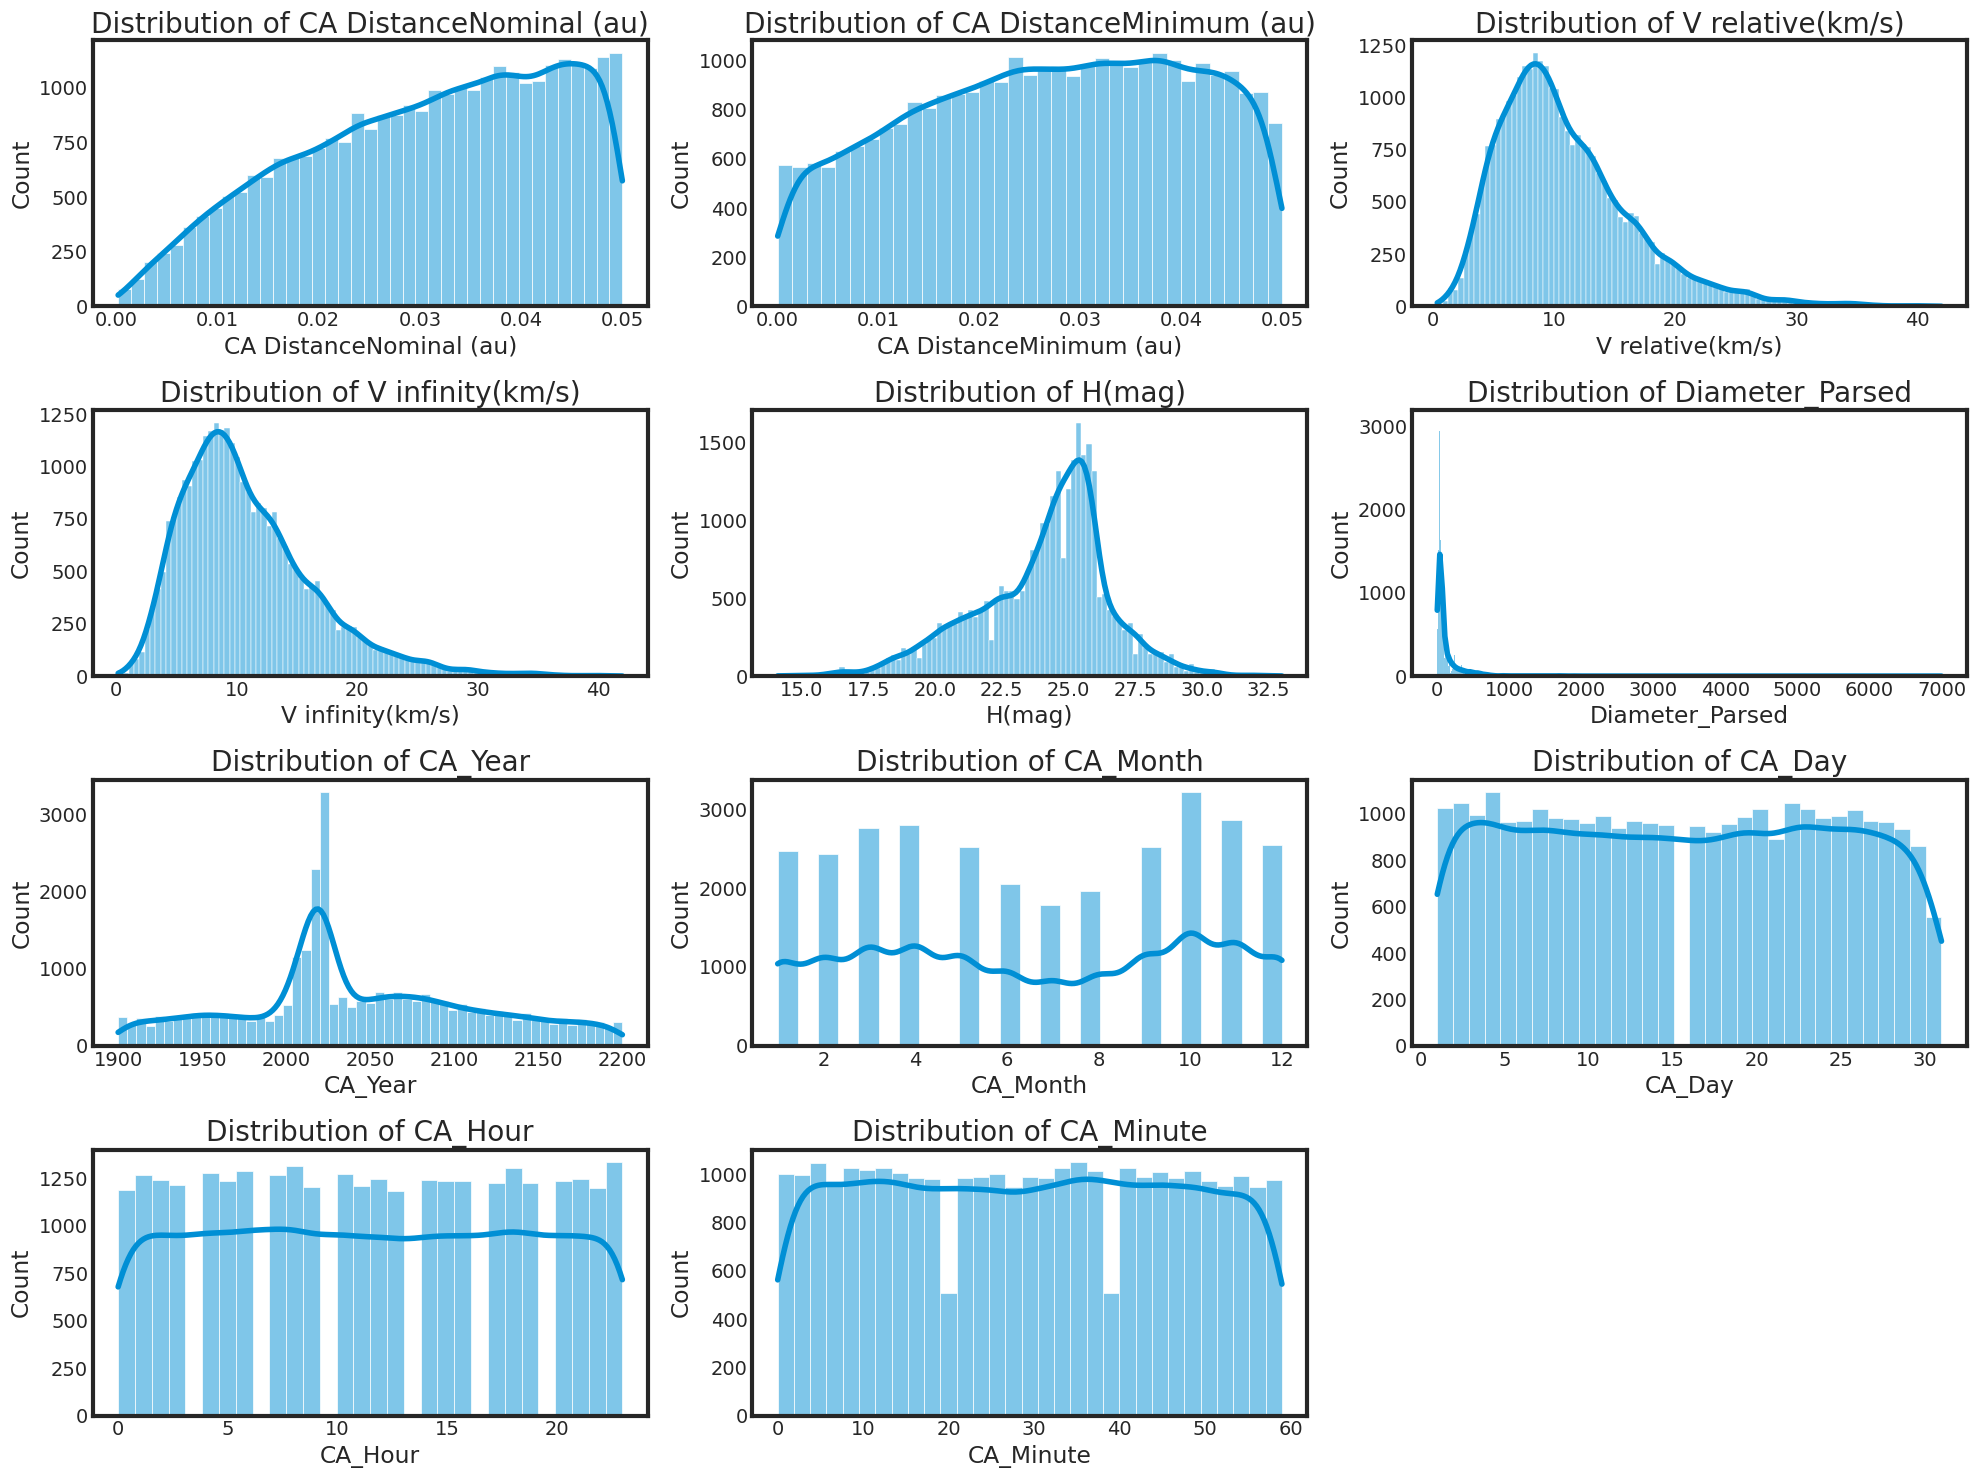

In [19]:

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# heatmap correlation plot

Text(0.5, 1.0, 'Correlation Heatmap')

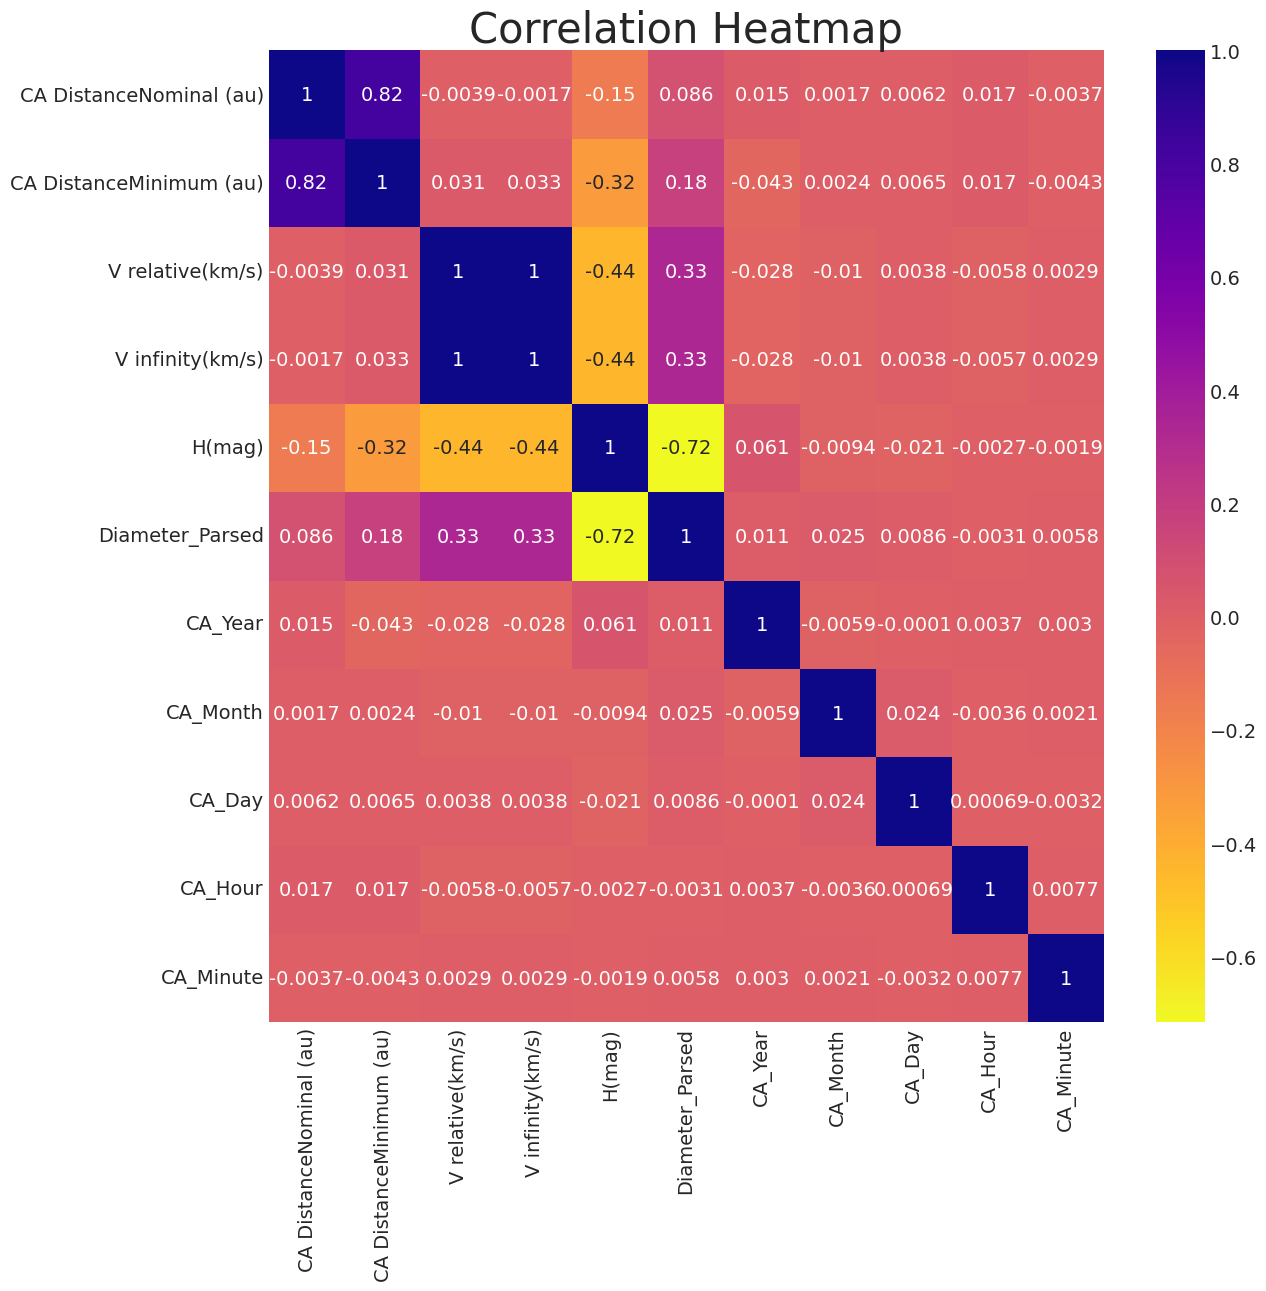

In [29]:
corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True, cmap="plasma_r")
plt.title('Correlation Heatmap', fontsize=30)

# box plot of all features with hue as rarity

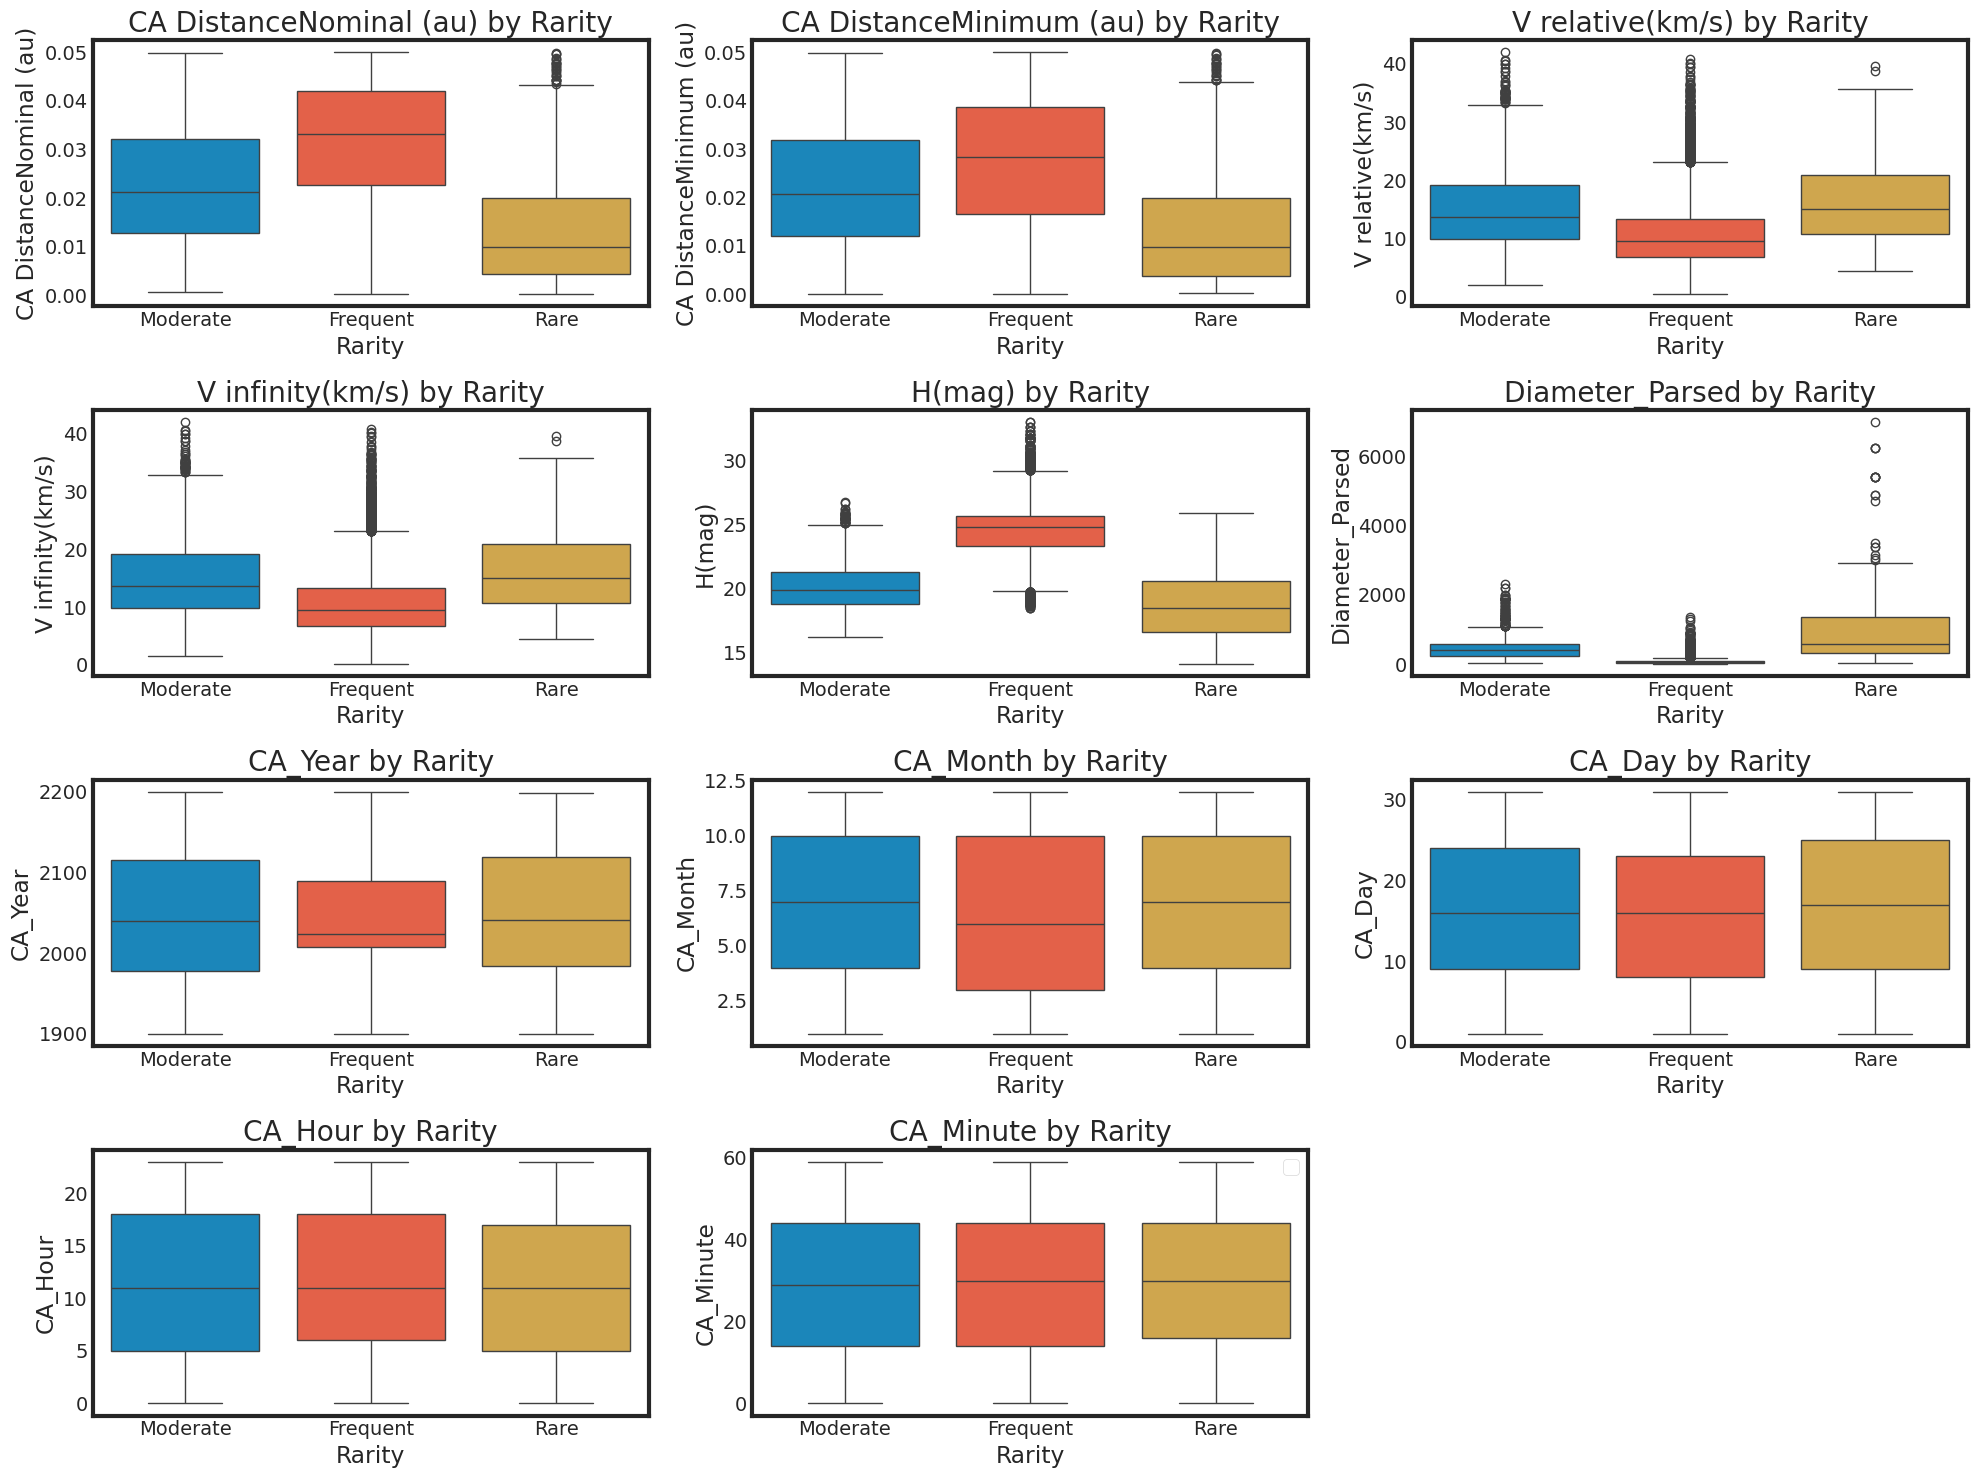

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x='Rarity', y=feature, data=df, hue='Rarity')
    plt.title(f'{feature} by Rarity')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# data preprocessing

In [22]:
#defining inputs and outputs as X and y respectively
X = df.drop(['Rarity'], axis=1)
y = df['Rarity']

# Encoding object type features using label encoder

In [23]:
# Encoding of categorical features
X=pd.get_dummies(X)

# Splitting The Dataset for Testing & Training

In [24]:
# Splitting The Dataset for Testing & Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [25]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler to balance the dataset
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)


# Standard Scalar¶
removes the mean and scales each feature/variable to unit variance.Then use the transform function on the training data so that we can scale the training data and also learn the scaling parameters of that data

In [26]:
# Standard Scaler Library
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

# Models with default parameters

Logistic Regression Accuracy: 0.9497
              precision    recall  f1-score   support

    Frequent       1.00      0.96      0.98      8137
    Moderate       0.63      0.88      0.74       718
        Rare       0.61      0.92      0.73       118

    accuracy                           0.95      8973
   macro avg       0.75      0.92      0.82      8973
weighted avg       0.96      0.95      0.95      8973

[[7782  355    0]
 [  18  632   68]
 [   1    9  108]]
------------------------------------------------------------------------------------------------------------------------


<Figure size 600x600 with 0 Axes>

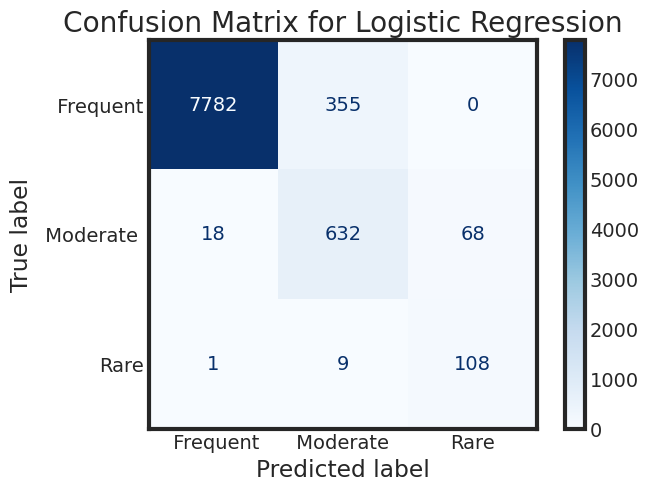

Random Forest Accuracy: 0.9517
              precision    recall  f1-score   support

    Frequent       1.00      0.95      0.98      8137
    Moderate       0.64      0.92      0.76       718
        Rare       0.67      0.99      0.80       118

    accuracy                           0.95      8973
   macro avg       0.77      0.96      0.84      8973
weighted avg       0.97      0.95      0.96      8973

[[7760  368    9]
 [   6  663   49]
 [   0    1  117]]
------------------------------------------------------------------------------------------------------------------------


<Figure size 600x600 with 0 Axes>

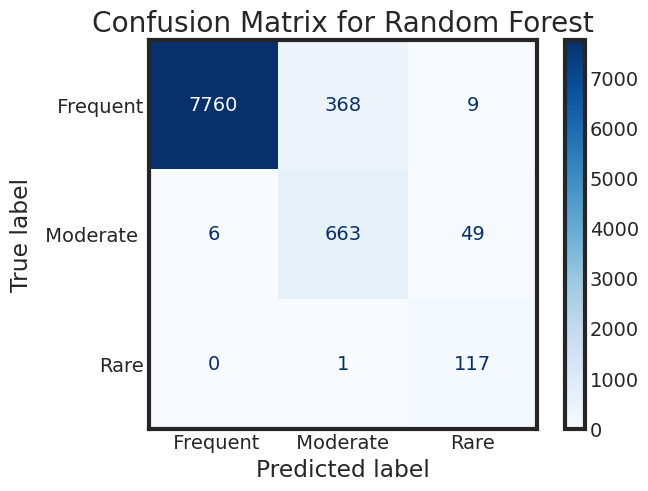

Gradient Boosting Accuracy: 0.9584
              precision    recall  f1-score   support

    Frequent       1.00      0.96      0.98      8137
    Moderate       0.68      0.94      0.79       718
        Rare       0.73      0.98      0.84       118

    accuracy                           0.96      8973
   macro avg       0.80      0.96      0.87      8973
weighted avg       0.97      0.96      0.96      8973

[[7806  322    9]
 [   7  678   33]
 [   0    2  116]]
------------------------------------------------------------------------------------------------------------------------


<Figure size 600x600 with 0 Axes>

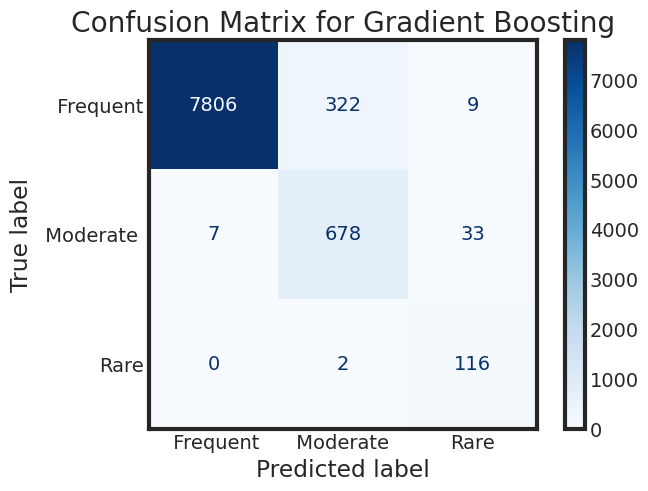

Support Vector Machine Accuracy: 0.9095
              precision    recall  f1-score   support

    Frequent       1.00      0.91      0.95      8137
    Moderate       0.47      0.86      0.61       718
        Rare       0.48      0.96      0.64       118

    accuracy                           0.91      8973
   macro avg       0.65      0.91      0.73      8973
weighted avg       0.95      0.91      0.92      8973

[[7433  683   21]
 [   0  615  103]
 [   0    5  113]]
------------------------------------------------------------------------------------------------------------------------


<Figure size 600x600 with 0 Axes>

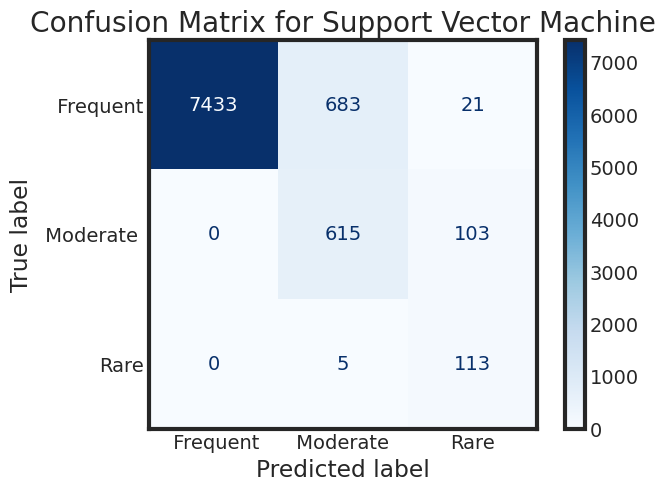

In [27]:
# Initialize classifiers
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print('-' * 120)

    # Plot confusion matrix without gridlines
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[' Frequent', ' Moderate ','Rare'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.gca().grid(False)  # Disable gridlines
    plt.show()


# hyperparameter tuning of models

Tuning hyperparameters for Logistic Regression...
Logistic Regression Best Parameters: {'C': 100, 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.9624
              precision    recall  f1-score   support

    Frequent       1.00      0.98      0.99      8137
    Moderate       0.75      0.80      0.77       718
        Rare       0.53      0.97      0.68       118

    accuracy                           0.96      8973
   macro avg       0.76      0.92      0.81      8973
weighted avg       0.97      0.96      0.96      8973

[[7946  191    0]
 [  39  575  104]
 [   0    3  115]]
------------------------------------------------------------------------------------------------------------------------


<Figure size 600x600 with 0 Axes>

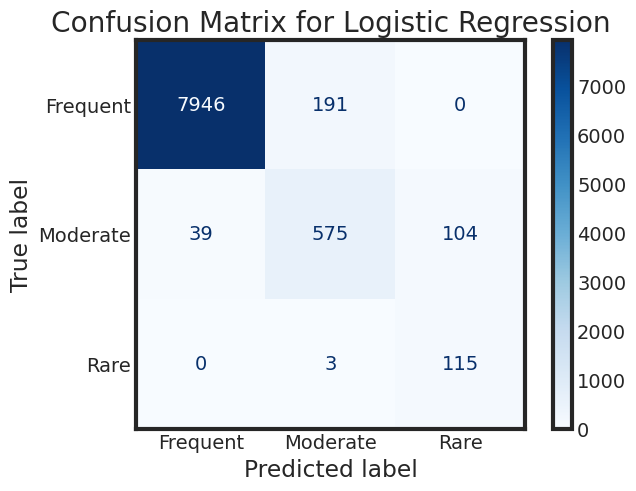

Tuning hyperparameters for Random Forest...
Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Accuracy: 0.9516
              precision    recall  f1-score   support

    Frequent       1.00      0.95      0.98      8137
    Moderate       0.64      0.92      0.76       718
        Rare       0.67      1.00      0.80       118

    accuracy                           0.95      8973
   macro avg       0.77      0.96      0.85      8973
weighted avg       0.97      0.95      0.96      8973

[[7758  370    9]
 [   6  663   49]
 [   0    0  118]]
------------------------------------------------------------------------------------------------------------------------


<Figure size 600x600 with 0 Axes>

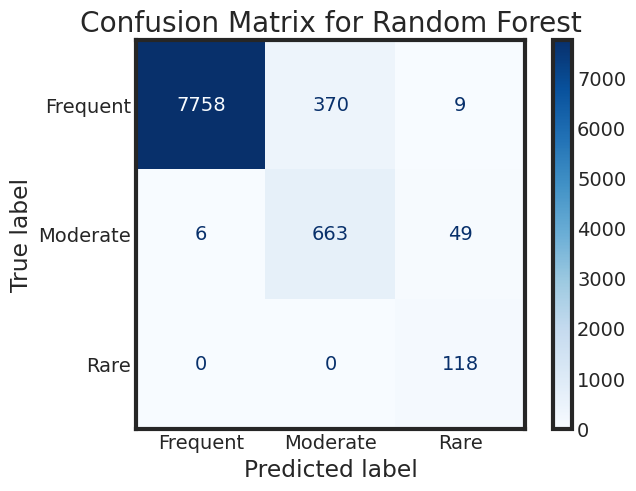

Tuning hyperparameters for Gradient Boosting...
Gradient Boosting Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
Gradient Boosting Accuracy: 0.9588
              precision    recall  f1-score   support

    Frequent       1.00      0.96      0.98      8137
    Moderate       0.68      0.94      0.79       718
        Rare       0.74      0.97      0.84       118

    accuracy                           0.96      8973
   macro avg       0.81      0.96      0.87      8973
weighted avg       0.97      0.96      0.96      8973

[[7813  315    9]
 [  12  675   31]
 [   0    3  115]]
------------------------------------------------------------------------------------------------------------------------


<Figure size 600x600 with 0 Axes>

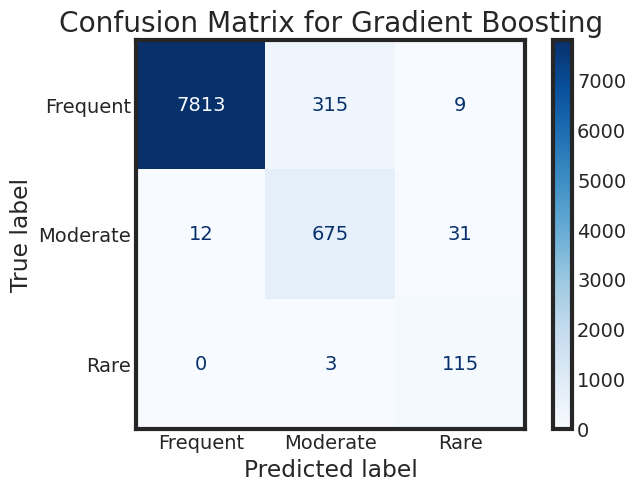

Tuning hyperparameters for Support Vector Machine...
Support Vector Machine Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Support Vector Machine Accuracy: 0.9642
              precision    recall  f1-score   support

    Frequent       1.00      0.97      0.98      8137
    Moderate       0.73      0.87      0.80       718
        Rare       0.67      0.95      0.79       118

    accuracy                           0.96      8973
   macro avg       0.80      0.93      0.86      8973
weighted avg       0.97      0.96      0.97      8973

[[7915  222    0]
 [  38  625   55]
 [   0    6  112]]
------------------------------------------------------------------------------------------------------------------------


<Figure size 600x600 with 0 Axes>

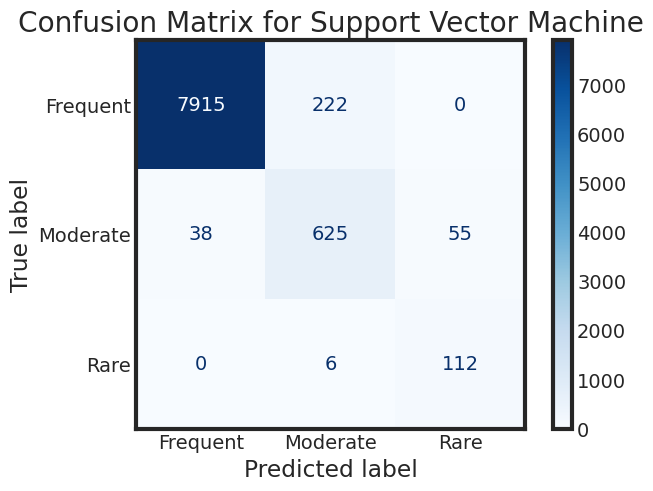

In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
}

# Initialize classifiers
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f'Tuning hyperparameters for {name}...')
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f'{name} Best Parameters: {grid_search.best_params_}')
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print('-' * 120)

    # Plot confusion matrix without gridlines
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Frequent', 'Moderate', 'Rare'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.gca().grid(False)  # Disable gridlines
    plt.show()